# Determine Bone Age using X-rays
### Aditya Hajare | https://github.com/aditya43

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import datetime, os
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

### Create Pandas Dataframes for training and testing..

In [2]:
# Load dataframes
train_df = pd.read_csv('/Users/adiinviter/work/AdityaHajare/Projects/Determine_Bone_Age_From_XRays/Bone-age-sample-dateset/boneage-training-dataset.csv')
test_df = pd.read_csv('/Users/adiinviter/work/AdityaHajare/Projects/Determine_Bone_Age_From_XRays/Bone-age-sample-dateset/boneage-test-dataset.csv')

# Appending file extension to id column for both training and testing dataframes
train_df['id'] = train_df['id'].apply(lambda x: str(x)+'.png')
test_df['Case ID'] = test_df['Case ID'].apply(lambda x: str(x)+'.png') 

train_df.head()

,id,boneage,male
0,1377.png,180,False
1,1378.png,12,False
2,1379.png,94,False
3,1380.png,120,True
4,1381.png,82,False


### Finding out number of male and female and creating a new column called "gender" as string

male      6833
female    5778
Name: gender, dtype: int64


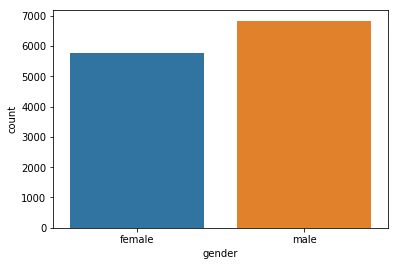

In [3]:
train_df['gender'] = train_df['male'].apply(lambda x: 'male' if x else 'female')
print(train_df['gender'].value_counts())
sns.countplot(x = train_df['gender'])

In [4]:
# Oldest person in the dataset
print('MAX age: ' + str(train_df['boneage'].max()) + ' months')

# Youngest person in the dataset
print('MIN age: ' + str(train_df['boneage'].min()) + ' months')

# Calculate mean bone age
mean_bone_age = train_df['boneage'].mean()
print('mean: ' + str(mean_bone_age))

# Calculate mediam bone age
print('median: ' +str(train_df['boneage'].median()))

# Standard deviation of bone age
std_bone_age = train_df['boneage'].std()

# Models perform better when features are normalised to have zero mean and unity standard deviation
# Using z score for the training
train_df['bone_age_z'] = (train_df['boneage'] - mean_bone_age)/(std_bone_age)

print(train_df.head())

MAX age: 228 months
MIN age: 1 months
mean: 127.3207517246848
median: 132.0
         id  boneage   male  gender  bone_age_z
0  1377.png      180  False  female    1.279181
1  1378.png       12  False  female   -2.800269
2  1379.png       94  False  female   -0.809109
3  1380.png      120   True    male   -0.177766
4  1381.png       82  False  female   -1.100498


Text(0.5,1,'Number of children in each age group')

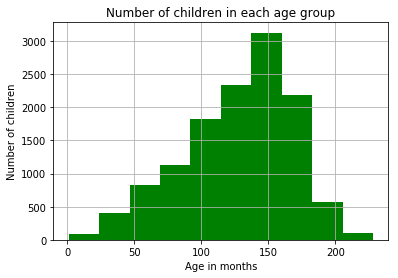

In [5]:
# Plotting a histogram for bone ages
train_df['boneage'].hist(color = 'green')
plt.xlabel('Age in months')
plt.ylabel('Number of children')
plt.title('Number of children in each age group')

Text(0.5,1,'Relationship between number of children and bone age z score')

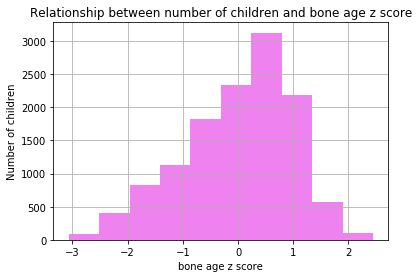

In [6]:
# Relationship between number of children and bone age z score
train_df['bone_age_z'].hist(color = 'violet')
plt.xlabel('bone age z score')
plt.ylabel('Number of children')
plt.title('Relationship between number of children and bone age z score')

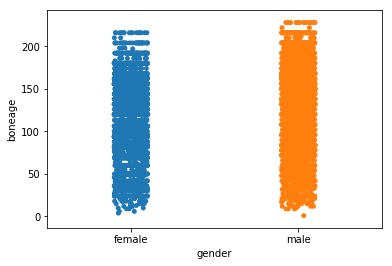

In [7]:
# Relationship between age and gender with a categorical scatter plot (swarmplot)
# Because of system limitations, i'm using stripplot here.. - Aditya Hajare

# sns.swarmplot(x = train_df['gender'], y = train_df['boneage'])
sns.stripplot(x = train_df['gender'], y = train_df['boneage'])    

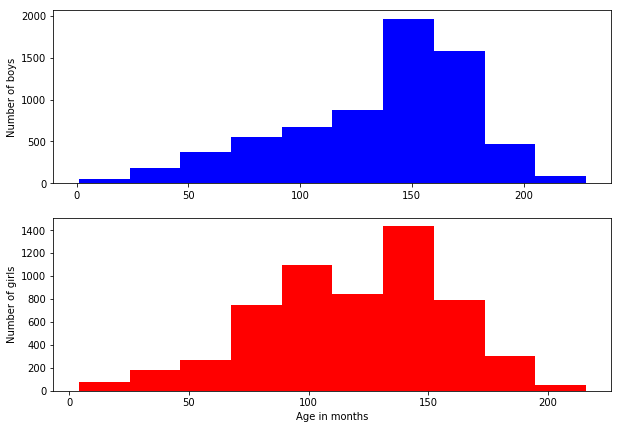

In [8]:
# Distribution of age within each gender 
male = train_df[train_df['gender'] == 'male']
female = train_df[train_df['gender'] == 'female']
fig, ax = plt.subplots(2,1)
ax[0].hist(male['boneage'], color = 'blue')
ax[0].set_ylabel('Number of boys')
ax[1].hist(female['boneage'], color = 'red')
ax[1].set_xlabel('Age in months')
ax[1].set_ylabel('Number of girls')
fig.set_size_inches((10,7))

In [9]:
# Splitting train dataframe into traininng and validation dataframes
df_train, df_valid = train_test_split(train_df, test_size = 0.2, random_state = 0)

### Looking into the dataset..

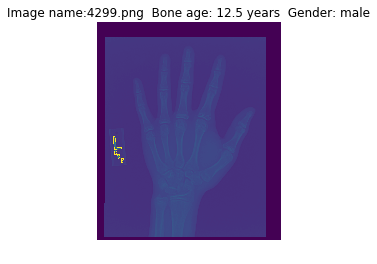

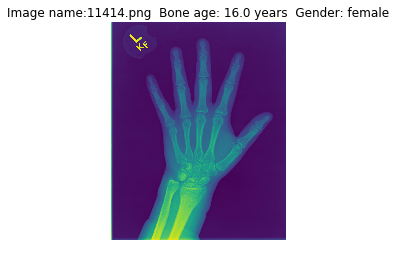

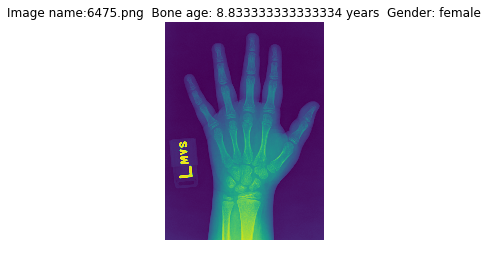

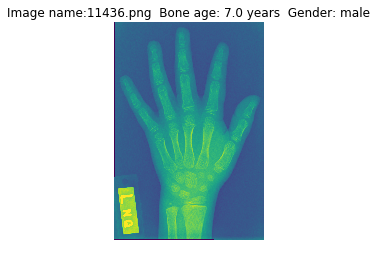

In [10]:
import matplotlib.image as mpimg
for filename, boneage, gender in train_df[['id','boneage','gender']].sample(4).values:
    img = mpimg.imread('/Users/adiinviter/work/AdityaHajare/Projects/Determine_Bone_Age_From_XRays/Bone-age-sample-dateset/boneage-training-dataset/boneage-training-dataset/'+ filename)
    
    plt.imshow(img)
    plt.title('Image name:{}  Bone age: {} years  Gender: {}'.format(filename, boneage/12, gender))
    plt.axis('off')
    plt.show()

### Setting up Image Data Generators!
##### We are using image data generators for both training, testing and preprocessing of images. Validation set is already broken off from training set. 

In [11]:
# Image preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from  keras.applications.xception import preprocess_input 

# Reducing down the size of the image 
img_size = 256

train_data_generator = ImageDataGenerator(preprocessing_function = preprocess_input)
val_data_generator = ImageDataGenerator(preprocessing_function = preprocess_input)

# Train data generator
train_generator = train_data_generator.flow_from_dataframe(
    dataframe = df_train,    
    directory= '/Users/adiinviter/work/AdityaHajare/Projects/Determine_Bone_Age_From_XRays/Bone-age-sample-dateset/boneage-training-dataset/boneage-training-dataset',
    x_col= 'id',
    y_col= 'bone_age_z',
    batch_size = 32,
    seed = 42,
    shuffle = True,
    class_mode= 'other',
#     class_mode='raw',
    flip_vertical = True,
    color_mode = 'rgb',
    target_size = (img_size, img_size))

# Validation data generator
val_generator = val_data_generator.flow_from_dataframe(
    dataframe = df_valid,
    directory= '/Users/adiinviter/work/AdityaHajare/Projects/Determine_Bone_Age_From_XRays/Bone-age-sample-dateset/boneage-training-dataset/boneage-training-dataset',
    x_col = 'id',
    y_col = 'bone_age_z',
    batch_size = 32,
    seed = 42,
    shuffle = True,
    class_mode = 'other',
#     class_mode='raw',
    flip_vertical = True,
    color_mode = 'rgb',
    target_size = (img_size, img_size))

# Test data generator
test_data_generator = ImageDataGenerator(preprocessing_function = preprocess_input)

test_generator = test_data_generator.flow_from_directory(
    directory= '/Users/adiinviter/work/AdityaHajare/Projects/Determine_Bone_Age_From_XRays/Bone-age-sample-dateset/boneage-test-dataset/boneage-test-dataset',
    shuffle = True,
    class_mode=None,
    color_mode = 'rgb',
    target_size = (img_size,img_size))

Using TensorFlow backend.


Found 10088 validated image filenames.
Found 2523 validated image filenames.
Found 0 images belonging to 0 classes.


In [12]:
test_X, test_Y = next(val_data_generator.flow_from_dataframe( 
                            df_valid, 
                            directory= '/Users/adiinviter/work/AdityaHajare/Projects/Determine_Bone_Age_From_XRays/Bone-age-sample-dateset/boneage-training-dataset/boneage-training-dataset',
                            x_col = 'id',
                            y_col = 'bone_age_z', 
                            target_size = (img_size, img_size),
                            batch_size = 2523,
                            class_mode = 'other'
#                             class_mode='raw',
                            )) 

Found 2523 validated image filenames.


### Definition to plot training and validation error as a function of epochs

In [13]:
def plot_it(history):
    '''function to plot training and validation error'''
    fig, ax = plt.subplots( figsize=(20,10))
    ax.plot(history.history['mae_in_months'])
    ax.plot(history.history['val_mae_in_months'])
    plt.title('Model Error')
    plt.ylabel('error')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')
    ax.grid(color='black')
    plt.show()

In [14]:
from keras.metrics import mean_absolute_error
def mae_in_months(x_p, y_p):
    '''function to return mae in months'''
    return mean_absolute_error((std_bone_age*x_p + mean_bone_age), (std_bone_age*y_p + mean_bone_age)) 

In [15]:
from tensorflow.keras.layers import GlobalMaxPooling2D, Dense,Flatten
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
from tensorflow.keras import Sequential

model_1 = tf.keras.applications.xception.Xception(input_shape = (img_size, img_size, 3), include_top = False, weights = 'imagenet')
model_1.trainable = True
model_2 = Sequential()
model_2.add(model_1)
model_2.add(GlobalMaxPooling2D())
model_2.add(Flatten())
model_2.add(Dense(10, activation = 'relu'))
model_2.add(Dense(1, activation = 'linear'))


# Compile model
model_2.compile(loss ='mse', optimizer= 'adam', metrics = [mae_in_months] )

# Model summary
model_2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 8, 8, 2048)        20861480  
_________________________________________________________________
global_max_pooling2d (Global (None, 2048)              0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                20490     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 20,881,981
Trainable params: 20,827,453
Non-trainable params: 54,528
_________________________________________________________________


In [16]:
# # Early stopping
# early_stopping = EarlyStopping(monitor='val_loss',
#                               min_delta=0,
#                               patience= 5,
#                               verbose=0, mode='auto')

# # Model checkpoint
# mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)

# # Tensorboard callback
# logdir = os.path.join(logs_dir,datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
# tensorboard_callback =  TensorBoard(logdir, histogram_freq = 1)

# # Reduce lr on plateau
# red_lr_plat = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)

# callbacks = [tensorboard_callback,early_stopping,mc, red_lr_plat]


# # Fit model
# history = model_2.fit_generator(train_generator,
#                             steps_per_epoch = 315,
#                             validation_data = val_generator,
#                             validation_steps = 1,
#                             epochs = 50,
#                             callbacks= callbacks)
# history
# %tensorboard --logdir logs
# plot_it(history)


### Evaluating the best saved model on the validation data and visualising results.

2523/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

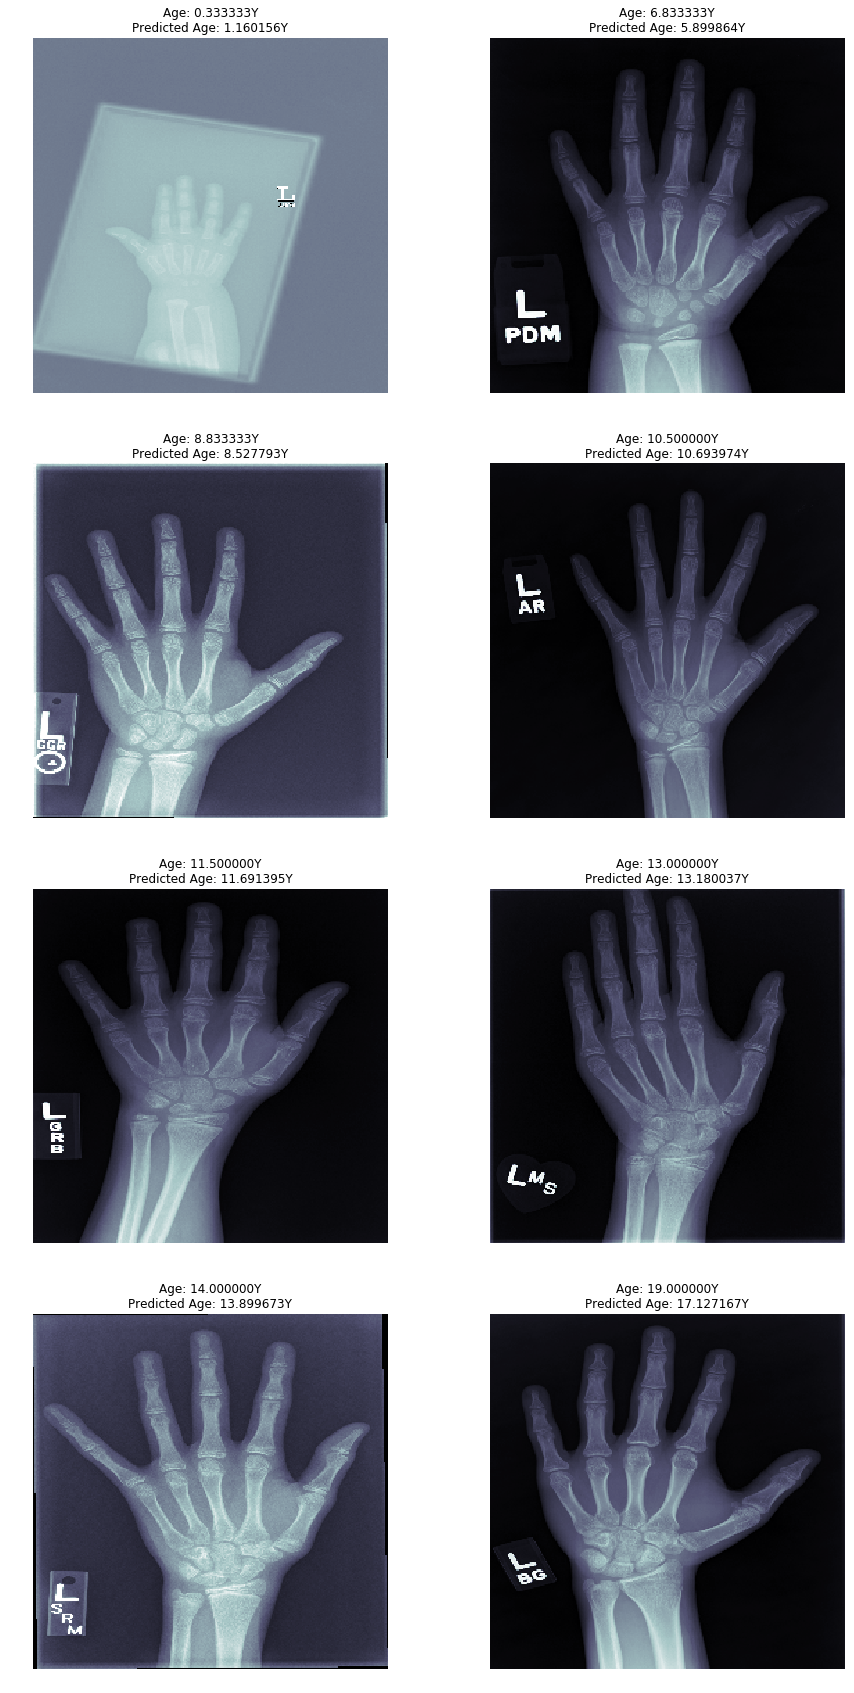

In [17]:
model_2.load_weights('/Users/adiinviter/work/AdityaHajare/Projects/Determine_Bone_Age_From_XRays/best_model.h5')
pred = mean_bone_age + std_bone_age*(model_2.predict(test_X, batch_size = 32, verbose = True))
test_months = mean_bone_age + std_bone_age*(test_Y)

ord_ind = np.argsort(test_Y)
ord_ind = ord_ind[np.linspace(0, len(ord_ind)-1, 8).astype(int)] # take 8 evenly spaced ones
fig, axs = plt.subplots(4, 2, figsize = (15, 30))
for (ind, ax) in zip(ord_ind, axs.flatten()):
    ax.imshow(test_X[ind, :,:,0], cmap = 'bone')
    ax.set_title('Age: %fY\nPredicted Age: %fY' % (test_months[ind]/12.0, 
                                                           pred[ind]/12.0))
    ax.axis('off')
fig.savefig('trained_image_predictions.png', dpi = 300)


Text(0,0.5,'Predicted Age (Months)')

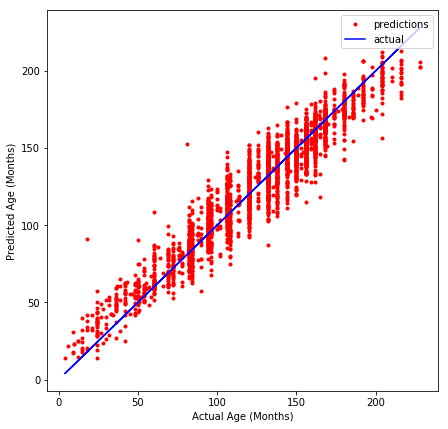

In [18]:
fig, ax = plt.subplots(figsize = (7,7))
ax.plot(test_months, pred, 'r.', label = 'predictions')
ax.plot(test_months, test_months, 'b-', label = 'actual')
ax.legend(loc = 'upper right')
ax.set_xlabel('Actual Age (Months)')
ax.set_ylabel('Predicted Age (Months)')